# Last Number Revisited with a Hidden Layer

Let's redo our last number example, now with a hidden layer.

In [1]:
import numpy as np
import random

We'll use the 2 best model data classes from before

In [2]:
class ModelDataScaled:
    """this is the model data for our "last number" training set.  We
    produce input of length N consisting of the numbers 0-9, and we set
    the output to be simply the last element of the input vector.  This
    version scales the data to lie between [0, 1]

    """    
    def __init__(self, N=10):
        self.N = N
        self.offset = 0.05
        self.scale_factor = 10
        
        # our model input data
        self.x = np.random.randint(0, high=10, size=N)
        self.x_scaled = self.x / self.scale_factor + self.offset

        # our scaled model output data
        self.y = np.array([self.x[-1]])
        self.y_scaled = np.array([self.x_scaled[-1]])
                                
    def interpret_result(self, out):
        """take the network output and undo the scaling and round it.

        """
        return max(0, min(9, int(self.scale_factor *
                                 np.round(out / self.offset) * self.offset)))

In [3]:
class ModelDataCategorical:
    """this is the model data for our "last number" training set.  We
    produce input of length N, consisting of numbers 0-9 and store
    the result in a 10-element array as categorical data.

    """
    def __init__(self, N=10):
        self.N = N
        
        # our model input data
        self.x = np.random.randint(0, high=10, size=N)
        self.x_scaled = self.x / 10 + 0.05
        
        # our scaled model output data
        self.y = np.array([self.x[-1]])
        self.y_scaled = np.zeros(10) + 0.01
        self.y_scaled[self.x[-1]] = 0.99
        
    def interpret_result(self, out):
        """take the network output and return the number we predict"""
        return np.argmax(out)

Now our network will store an additional array, ${\bf B}$, and take the size of the
hidden layer as an input.

In [4]:
class NeuralNetwork:
    """A neural network class with a single hidden layer."""

    def __init__(self, num_training_unique=100,
                 data_class=None, hidden_layer_size=20):

        self.num_training_unique = num_training_unique

        self.train_set = []
        for _ in range(self.num_training_unique):
            self.train_set.append(data_class())

        # initialize our matrix with Gaussian normal random numbers
        # we get the size from the length of the input and output
        model = self.train_set[0]
        self.N_out = len(model.y_scaled)
        self.N_in = len(model.x_scaled)
        self.N_hidden = hidden_layer_size

        # we will initialize the weights with Gaussian normal random
        # numbers centered on 0 with a width of 1/sqrt(n), where n is
        # the length of the input state

        # A is the set of weights between the hidden layer and output layer
        self.A = np.random.normal(0.0, 1.0/np.sqrt(self.N_hidden), (self.N_out, self.N_hidden))

        # B is the set of weights between the input layer and hidden layer
        self.B = np.random.normal(0.0, 1.0/np.sqrt(self.N_in), (self.N_hidden, self.N_in))

    def g(self, xi):
        """our sigmoid function that operates on the layers"""
        return 1.0/(1.0 + np.exp(-xi))

    def train(self, n_epochs=10, eta=0.2):
        """Train the neural network by doing gradient descent with back
        propagation to set the matrix elements in B (the weights
        between the input and hidden layer) and A (the weights between
        the hidden layer and output layer)

        """

        for _ in range(n_epochs):
            random.shuffle(self.train_set)
            for model in self.train_set:

                # make the input and output data column vectors
                x = model.x_scaled.reshape(self.N_in, 1)
                y = model.y_scaled.reshape(self.N_out, 1)

                # propagate the input through the network
                z_tilde = self.g(self.B @ x)
                z = self.g(self.A @ z_tilde)

                # compute the errors (backpropagate to the hidden layer)
                e = z - y
                e_tilde = self.A.T @ e

                # corrections
                dA = -2 * eta * e * z * (1 - z) @ z_tilde.T
                dB = -2 * eta * e_tilde * z_tilde * (1 - z_tilde) @ x.T

                self.A[:, :] += dA
                self.B[:, :] += dB

    def predict(self, model):
        """ predict the outcome using our trained matrix A """
        z = self.g(self.A @ (self.g(self.B @ model.x_scaled)))
        return model.interpret_result(z)
    
    def check_accuracy(self):
        """use the trained network on the training data and return
        the fraction we get correct"""
        
        n_right = 0
        for model in self.train_set:
            y_nn = self.predict(model)
            if y_nn == model.y:
                n_right += 1
        return n_right / len(self.train_set)

We'll focus on the categorical data

In [37]:
nn = NeuralNetwork(num_training_unique=1000,
                   hidden_layer_size=50, data_class=ModelDataScaled)
nn.train(n_epochs=100)

In [38]:
frac = nn.check_accuracy()
print(f"fraction correct: {frac}")

fraction correct: 0.634


In [39]:
err = []
npts = 10000
n_right = 0
for k in range(npts):
    model = ModelDataScaled()
    y_nn = nn.predict(model)
    if y_nn == model.y:
        n_right += 1
    err.append(abs(y_nn - model.y))
    
print(f"fraction correct: {n_right / npts}")

fraction correct: 0.6138


### Effect of the number of epochs

Let's see what effect the number of epochs has.

In [28]:
n_epochs = [1, 2, 4, 8, 16, 32, 64]
accuracy = []

for nep in n_epochs:
    nn = NeuralNetwork(num_training_unique=1000,
                       hidden_layer_size=50, data_class=ModelDataCategorical)    
    nn.train(n_epochs=nep)
    accuracy.append(nn.check_accuracy())

In [29]:
import matplotlib.pyplot as plt

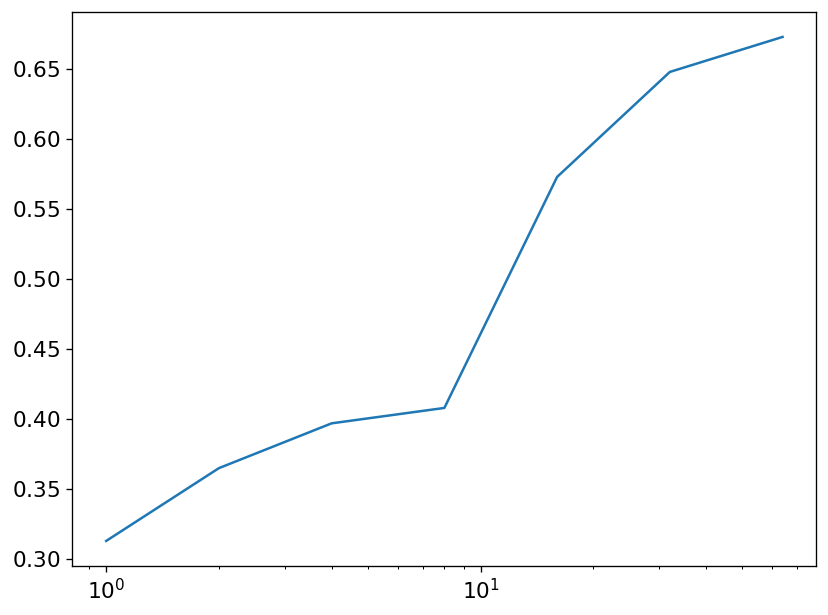

In [30]:
fig, ax = plt.subplots()

ax.plot(n_epochs, accuracy)
ax.set_xscale("log")

### Effect of the training sample size

Now let's vary the size of the training sample

In [35]:
ntrain = [10, 30, 100, 300, 1000, 3000, 10000]
accuracy = []

for nt in ntrain:
    nn = NeuralNetwork(num_training_unique=nt,
                       hidden_layer_size=50, data_class=ModelDataCategorical)    
    nn.train(n_epochs=50)
    accuracy.append(nn.check_accuracy())

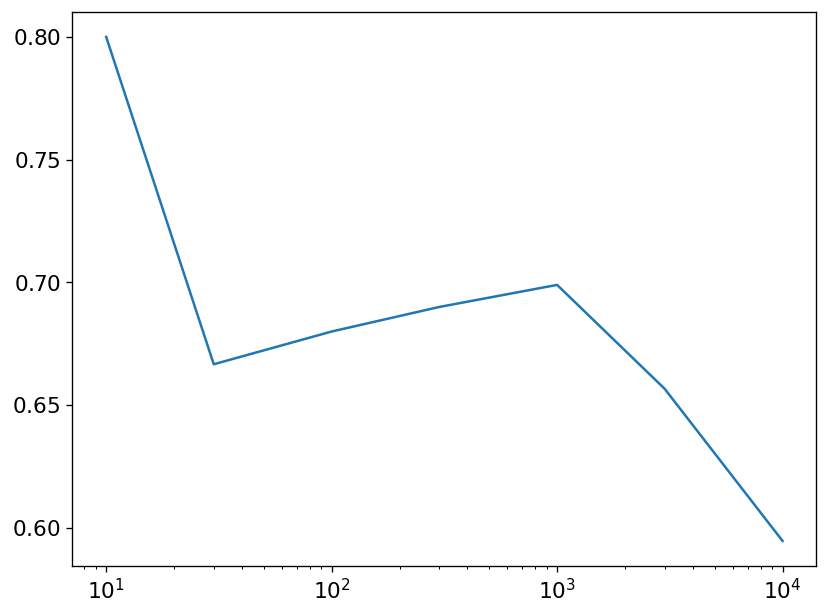

In [36]:
fig, ax = plt.subplots()

ax.plot(ntrain, accuracy)
ax.set_xscale("log")

## Effect of hidden layer size

In [42]:
nhidden = [5, 10, 20, 50, 100, 200]
accuracy = []

for nh in nhidden:
    nn = NeuralNetwork(num_training_unique=1000,
                       hidden_layer_size=nh, data_class=ModelDataCategorical)    
    nn.train(n_epochs=100)
    accuracy.append(nn.check_accuracy())

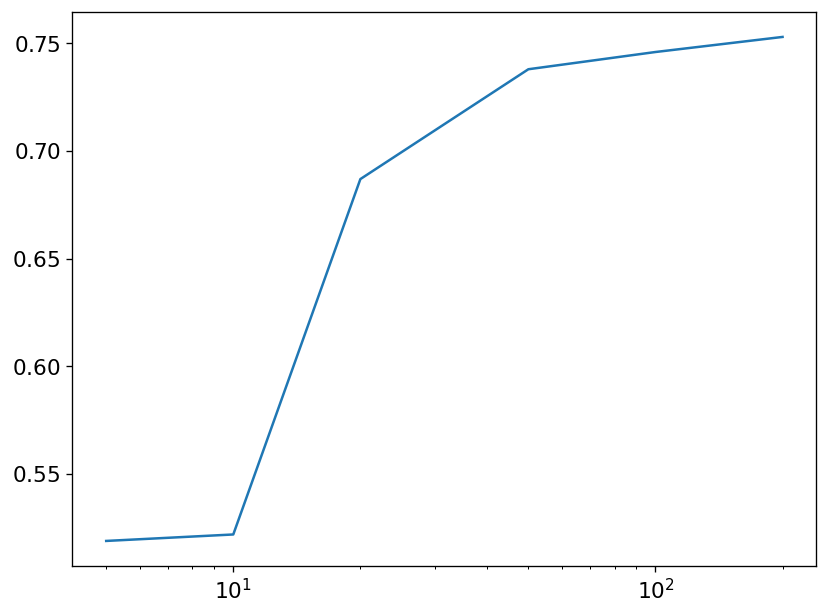

In [43]:
fig, ax = plt.subplots()

ax.plot(nhidden, accuracy)
ax.set_xscale("log")